In [1]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 31.6 MB/s 
     |████████████████████████████████| 9.8 MB 42.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# **Import Packages**

In [2]:
#Import packages
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import  timedelta
import pickle
import math

pd.set_option('display.max_columns', None)

In [3]:
import sys
import statsmodels as ss
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

In [4]:
from sklearn.metrics import mean_squared_error

# **Load and preprocess data**

**Load data**

In [5]:
df = pd.read_csv('/content/drive/MyDrive/data.csv', encoding="cp1252")
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
#Cac thuoc tinh cua du lieu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


**Missing - value**

In [7]:
#Kiểm tra các giá trị nào còn thiếu _ missing-value
#Nếu có thuộc tính thiếu giá trị, thì thêm giá trị
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Nhận thấy, chỉ có 2 thuộc tính có missing-value là Description và CustomerID. Ta sẽ thêm giá trị cho thuộc tính CustomerID để có thể sử dụng groupby, chọn số âm

In [8]:
df['CustomerID'].fillna(-999, inplace=True)

**Filtering unexpected invoices**

Các hóa đơn có InvoiceNo bắt đầu bằng chữ '**C**' là các đơn hàng đã bị hủy. Vì chúng không được tính vào tổng doanh thu, ta có thể xóa các trường giao dịch này khỏi dữ liệu.

Tương tự, một số giao dịch có InvoiceNo bắt đầu bằng '**A**' có liên quan đến việc điều chỉnh nợ khó đòi.

In [9]:
# Những hóa đơn bị hủy (Canceled invoices)
cancel_df = df[df['InvoiceNo'].str.contains('C', na=False)]
cancel_df.reset_index(drop=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
1,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
2,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
3,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
4,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
9283,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
9284,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
9285,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
9286,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [10]:
#Những hóa đơn liên quan đến việc nợ khó đòi
bad_dept = df[df['InvoiceNo'].str.contains('A', na=False)]
bad_dept.reset_index(drop=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,A563185,B,Adjust bad debt,1,8/12/2011 14:50,11062.06,-999.0,United Kingdom
1,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,-999.0,United Kingdom
2,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,-999.0,United Kingdom


In [11]:
#Những hóa đơn không đóng góp gì vào doanh thu cửa hàng
df[df['UnitPrice']==0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,-999.0,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,-999.0,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,-999.0,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,-999.0,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,-999.0,United Kingdom
...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,-999.0,United Kingdom
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,12/8/2011 13:58,0.0,-999.0,United Kingdom
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,12/8/2011 13:58,0.0,-999.0,United Kingdom
538554,581408,85175,NaN,20,12/8/2011 14:06,0.0,-999.0,United Kingdom


In [12]:
#Loại bỏ các đơn không có tác dụng đến doanh thu của cửa hàng
trans_df = df[~df['InvoiceNo'].str.contains('C', na=False)]
trans_df = trans_df[~trans_df.InvoiceNo.str.contains('A', na=False)]
trans_df = trans_df[trans_df['UnitPrice']!=0]
trans_df.reset_index(drop=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
530098,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
530099,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
530100,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
530101,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [13]:
# Transactions Income - Tính tổng doanh thu mỗi hóa đơn
trans_df.loc[:,'Revenue'] = np.nan
trans_df.loc[:,'Revenue'] = trans_df.loc[:,'Quantity']*trans_df.loc[:,'UnitPrice']

trans_df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom,54.08


In [14]:
#Test một số trường
#trans_df['InvoiceNo'].str.startswith('A').any()
#(trans_df['UnitPrice'] < 0).any()
(trans_df['Quantity'] == 0).any()

False

**Group Invoices per day**

In [15]:
#Convert time to default format in python (date only)
trans_df['InvoiceDate'] = pd.to_datetime(trans_df['InvoiceDate']).dt.date

trans_df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [16]:
#Tạo một table chứa dữ liệu về tổng số hóa đơn trong một ngày 
inv_pdt = trans_df[['InvoiceDate', 'InvoiceNo']]
inv_pdt = inv_pdt.groupby('InvoiceDate').nunique().reset_index()

inv_pdt.head(10)

,InvoiceDate,InvoiceNo
0,2010-12-01,127
1,2010-12-02,142
2,2010-12-03,68
3,2010-12-05,88
4,2010-12-06,102
5,2010-12-07,84
6,2010-12-08,116
7,2010-12-09,107
8,2010-12-10,77
9,2010-12-12,44


In [17]:
#Đặt date làm index cho chuỗi thời gian
inv_pdt = inv_pdt.set_index('InvoiceDate', drop=True)

inv_pdt

,InvoiceNo
InvoiceDate,
2010-12-01,127
2010-12-02,142
2010-12-03,68
2010-12-05,88
2010-12-06,102
...,...
2011-12-05,127
2011-12-06,115
2011-12-07,106


Nhận thấy dữ liệu còn thiếu nhiều ngày không có giá trị, mặc định thêm với giá trị 0

In [23]:
#Thêm cả những ngày không có giá đóng cửa nào vào DF
srt_date = inv_pdt.index.min()
end_date = inv_pdt.index.max()
idx = pd.date_range(srt_date, end_date)

inv_pdt.index = pd.DatetimeIndex(inv_pdt.index)
inv_pdt = inv_pdt.reindex(idx, fill_value=0)

inv_pdt.head(5)

,InvoiceNo
2010-12-01,127
2010-12-02,142
2010-12-03,68
2010-12-04,0
2010-12-05,88


In [24]:
#Đổi tên columns để dễ thao tác
inv_pdt.columns = ['Total invoices']
inv_pdt.columns = ['Total invoices']

In [25]:
inv_pdt.head()

,Total invoices
2010-12-01,127
2010-12-02,142
2010-12-03,68
2010-12-04,0
2010-12-05,88


Thu được chuỗi thời gian là tổng số hóa đơn bán được theo ngày, trong khoảng thời gian từ 1/12/2010 đến 31/10/2011

# **Check for Stationarity**

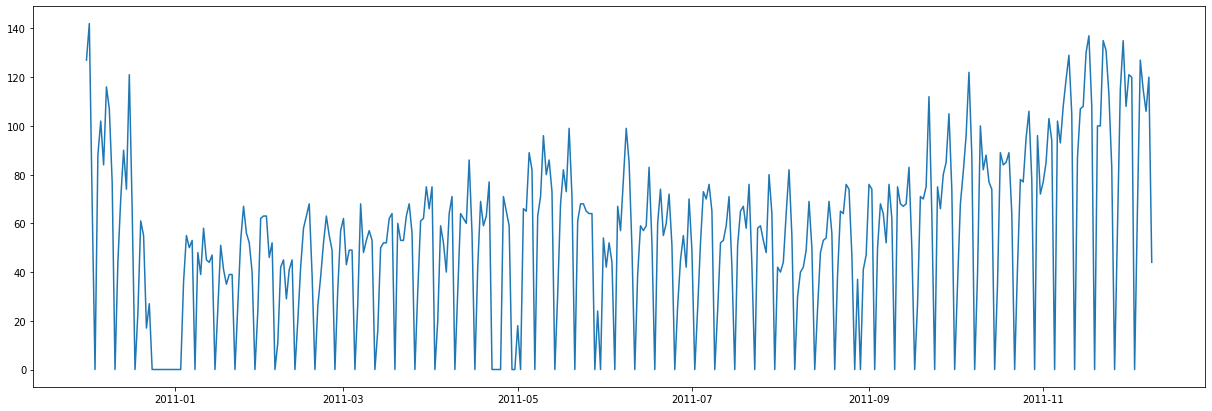

In [26]:
#Visualize data
plt.figure(figsize=(21, 7))
plt.plot(inv_pdt['Total invoices'])

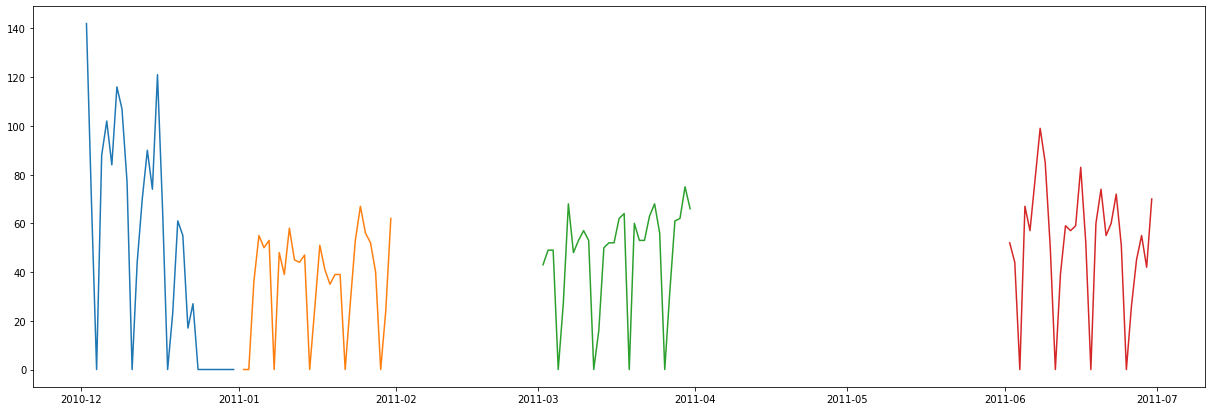

In [27]:
#Kiểm tra tính chu kỳ theo tháng
plt.figure(figsize=(21, 7))
plt.plot(inv_pdt['Total invoices'][1:31])
plt.plot(inv_pdt['Total invoices'][32:62])
plt.plot(inv_pdt['Total invoices'][91:121])
plt.plot(inv_pdt['Total invoices'][183:212])

Phân tích chuỗi thành **3 thành phần** : xu hướng (**trend**), thời vụ (**seasonality**) và còn lại (**residual**)

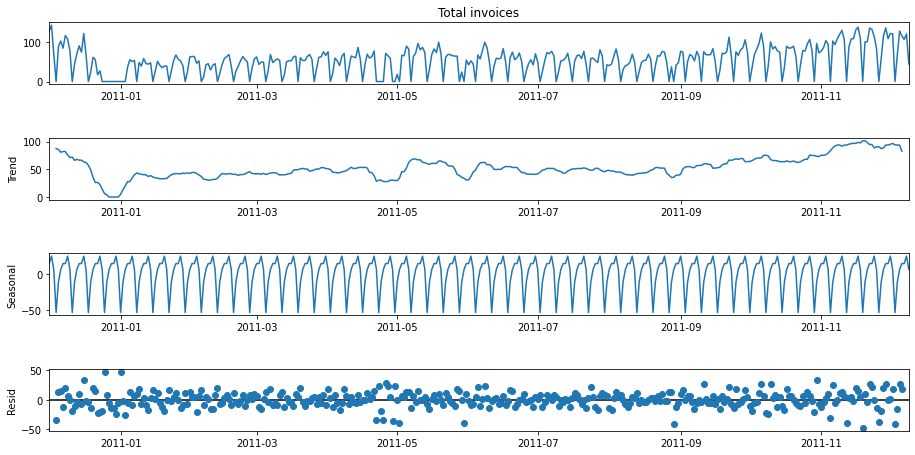

In [28]:
decomp = seasonal_decompose(inv_pdt['Total invoices'])
fig = decomp.plot()
fig.set_size_inches(14, 7)

Nhận thấy, chuỗi thời gian có tính mùa vụ và dường như có xu hướng tăng.

Kiểm tra tính ổn định bằng giả thuyết **Augmented Dickey-Fuller Test**

In [29]:
from statsmodels.tsa.stattools import adfuller

fuller_test = adfuller(inv_pdt['Total invoices'])

print('ADF Statistic: %f' % fuller_test[0])
print('p-value: %f' % fuller_test[1])

ADF Statistic: -2.685736
p-value: 0.076539


In [30]:
#Định nghĩa 1 hàm kiểm tra tính ổn định của chuỗi
def test_p_value(data):
  fuller_test = adfuller(data)
  print('p-value : %.5f' % fuller_test[1])
  if(fuller_test[1] <= 0.05):
    print('Chuỗi ổn định')
  else:
    print('Chuỗi KHÔNG ổn định')

In [31]:
#test
test_p_value(inv_pdt['Total invoices'])

p-value : 0.07654
Chuỗi KHÔNG ổn định


**Chuyển chuỗi thành ổn định** bằng cách **áp dụng Differencing**

Vì ADF kiểm tra thấy chuỗi chưa ổn định, và còn có tính thời vụ theo tuần nên cần áp dụng **seasonal difference**

In [32]:
inv_pdt['Seasonal_diff'] = inv_pdt['Total invoices'] - inv_pdt['Total invoices'].shift(7)
# inv_pdt['First_diff'] = inv_pdt['Total invoices'] - inv_pdt['Total invoices'].shift(1)
# inv_pdt['Both_diff'] = inv_pdt['Seasonal_diff'] - inv_pdt['Seasonal_diff'].shift(1)

p-value : 0.00000
Chuỗi ổn định


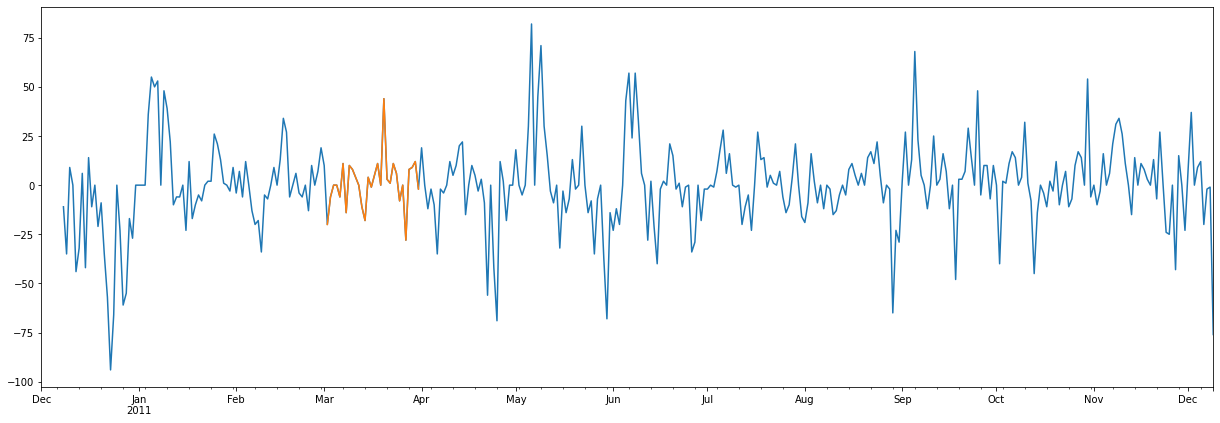

In [33]:
#Seasonal Difference
plt.figure(figsize=[21,7])
inv_pdt['Seasonal_diff'].plot()
inv_pdt['Seasonal_diff'][91:121].plot()

#Xác định tính ổn định của chuỗi
test_p_value(inv_pdt['Seasonal_diff'].dropna())

Nhận thấy, tính thời vụ đã không còn, và chuỗi đã ổn định. Như vậy, ta chỉ cần áp dụng Seasonal difference là đã thỏa mãn.

# **Xây dựng model SARIMA**

**Chọn tham số** xuất phát bằng biểu đồ **ACF** và **PACF**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


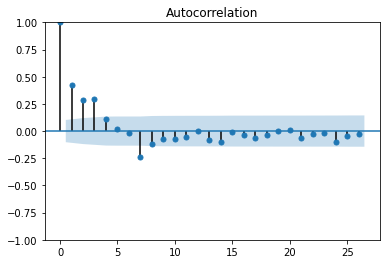

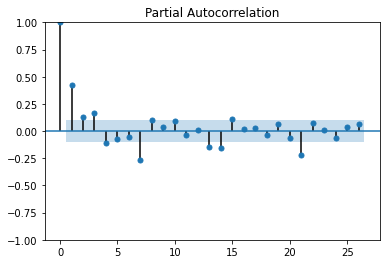

In [34]:
q_para = plot_acf(inv_pdt['Seasonal_diff'].dropna())

p_para = plot_pacf(inv_pdt['Seasonal_diff'].dropna())

Nhìn vào biểu đồ ACF/PACF thấy : 

*   **PACF** có mức tăng đột biến âm đáng kể tại các vị trí **lag(độ trễ) 7, 14, 21**,... (đây là suy giảm cấp mũ _ *expotential decay*) ; và bên cạnh đó ở biểu đồ **ACF** có mức tăng đột biến âm đáng kể tại **lag 7**, qua đó cho thấy giá trị **Q = 1** (thể hiện tính thời vụ theo tuần) và giá trị **P = 0**
*   **ACF**  có mức tăng đột biến dương đáng kể tại **lag 1, 2 và 3** nên **q = 3**
*   **PACF** có mức đột biến dương đáng kể tại **lag 1** nên **p = 1**

Như vậy, với tham số khởi đầu của mô hình SARIMA, ta chọn bộ tham số tiềm năng là **SARIMA(1, 0, 3)x(0, 1, 1, 7)** : 

**Mô hình SARIMA sơ bộ**

*   Triển khai mô hình SARIMA sơ bộ sử dụng các thông số xác định từ các biểu đồ ACF và PACF.
*   Kiểm tra chất lượng của mô hình bằng các đồ thị ACF và PACF mới về phần còn lại của mô hình (*model's residuals*).

In [35]:
# fit SARIMA based on helper plots
sar = sm.tsa.statespace.SARIMAX(inv_pdt['Total invoices'], 
                                order=(1,0,3), 
                                seasonal_order=(0,1,1,7)).fit(max_iter = 50, method = 'powell')
sar.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  FutureWarning


Optimization terminated successfully.
         Current function value: 4.166926
         Iterations: 6
         Function evaluations: 411


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      Total invoices   No. Observations:                  374
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 7)   Log Likelihood               -1558.430
Date:                             Sun, 17 Oct 2021   AIC                           3128.861
Time:                                     17:30:52   BIC                           3152.293
Sample:                                 12-01-2010   HQIC                          3138.171
                                      - 12-09-2011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8693      0.046     19.006      0.000       0.780       0.959
ma.L1         -0.4717      0.063     -7.494      0.000      -0.595      -0.348
ma.L2         -0.1433      0.055     -2.593      0.010      -0.252      -0.035
ma.L3          0.1197      0.052      2.308      0.021       0.018       0.221
ma.S.L7       -0.7674      0.040    -19.058      0.000      -0.846      -0.688
sigma2       280.6779     15.774     17.794      0.000     249.761     311.595
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                48.06
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.37
Prob(H) (two-sided):                  0.93   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


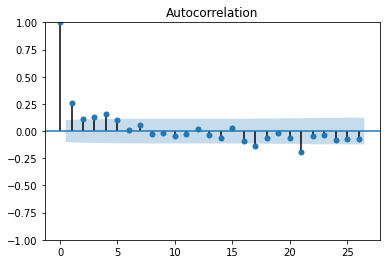

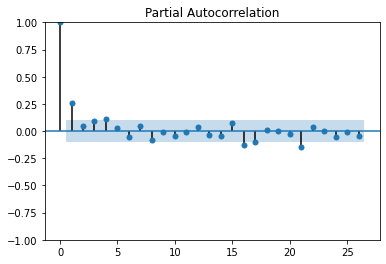

In [36]:
res = sar.resid

f1 = plot_acf(res.dropna())

f2 = plot_pacf(res.dropna())

Trong đồ thị trên, 
*   Không có đột biến đáng kể nào ngoại trừ ở độ trễ lag 1 trong các đồ thị ACF và PACF của phần dư của mô hình.
*   Các thông số này là điểm khởi đầu có thể chấp nhận được đối với mô hình và có thể được cải thiện hơn nữa bằng cách sử dụng tìm kiếm lưới (Grid Search)



**Grid Search bằng Auto_ARIMA**

In [37]:
#Chọn tham số tự động
#Import the library
from pmdarima import auto_arima
  
#Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
  
#Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(inv_pdt['Total invoices'], start_p = 1, start_q = 1,
                          max_p = 4, max_q = 4, m = 7,
                          start_P = 0, start_Q = 1,
                          max_P = 4, max_Q = 4, seasonal = True,
                          d = 0, D = 1, trace = True,
                          error_action ='ignore')           
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=3132.855, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3298.330, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3194.963, Time=0.36 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=3185.637, Time=0.41 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3296.336, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=3217.516, Time=0.18 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=3119.016, Time=0.81 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=3183.005, Time=0.53 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=3120.328, Time=1.83 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=3120.614, Time=1.88 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=3119.342, Time=1.43 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=3165.513, Time=1.08 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=inf, Time=3.87 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=3161.548, Time=0.77 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  374
Model:             SARIMAX(3, 0, 0)x(1, 1, [1], 7)   Log Likelihood               -1549.911
Date:                             Sun, 17 Oct 2021   AIC                           3111.823
Time:                                     17:32:44   BIC                           3135.255
Sample:                                          0   HQIC                          3121.133
                                             - 374                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4096      0.043      9.462      0.000       0.325       0.494
ar.L2          0.0709      0.051      1.397      0.162      -0.029       0.170
ar.L3          0.2315      0.046      5.006      0.000       0.141       0.322
ar.S.L7        0.2900      0.058      4.959      0.000       0.175       0.405
ma.S.L7       -0.8906      0.044    -20.434      0.000      -0.976      -0.805
sigma2       267.1281     15.782     16.926      0.000     236.196     298.060
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                38.02
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.30
Prob(H) (two-sided):                  0.71   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Sau khi thực hiện tìm kiếm, bộ tham số tốt nhất cho mô hình là **SARIMA(3,0,0)x(1,1,1,7)** vì có chỉ số AIC thấp nhất

**Walk Forward Validation**

In [38]:
X = inv_pdt['Total invoices'].squeeze().values

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
residuals = list()

# walk-forward validation
for t in range(len(test)):
    model = SARIMAX(endog=history,order=(3,0,0),seasonal_order=(1,1,1,7),trend='c',enforce_invertibility=False)
    model_fit = model.fit(maxiter=1000)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    residuals.append(yhat-obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
model = SARIMAX(endog=history,order=(3,0,0),seasonal_order=(1,1,1,7),trend='c',enforce_invertibility=False)
model_fit = model.fit(maxiter=1000)

predicted=65.151849, expected=52.000000
predicted=77.384195, expected=76.000000
predicted=61.710524, expected=62.000000
predicted=1.338359, expected=0.000000
predicted=40.425319, expected=75.000000
predicted=72.696362, expected=68.000000
predicted=67.360209, expected=67.000000
predicted=69.506937, expected=68.000000
predicted=79.635133, expected=83.000000
predicted=61.545318, expected=50.000000
predicted=1.303917, expected=0.000000
predicted=49.890732, expected=27.000000
predicted=45.692535, expected=71.000000
predicted=67.809372, expected=70.000000
predicted=61.602876, expected=75.000000
predicted=83.484085, expected=112.000000
predicted=71.034751, expected=64.000000
predicted=10.928544, expected=0.000000
predicted=43.576484, expected=75.000000
predicted=78.480520, expected=66.000000
predicted=68.398098, expected=80.000000
predicted=82.897773, expected=85.000000
predicted=94.318541, expected=105.000000
predicted=70.923747, expected=74.000000
predicted=15.524785, expected=0.000000
pred

**Đánh giá kết quả**

*   Quan sát phân bố giá trị lỗi


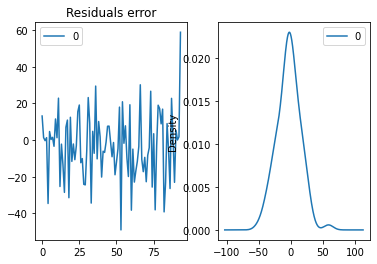

In [40]:
fig, axes = plt.subplots(1, 2)

residuals = pd.DataFrame(residuals)
residuals.plot(ax=axes[0])
axes[0].set_title('Residuals error')

residuals.plot(kind='kde', ax=axes[1])

plt.show()

Nhận thấy, giá trị lỗi gần phân phối chuẩn với mean=0 nên model có vẻ tốt

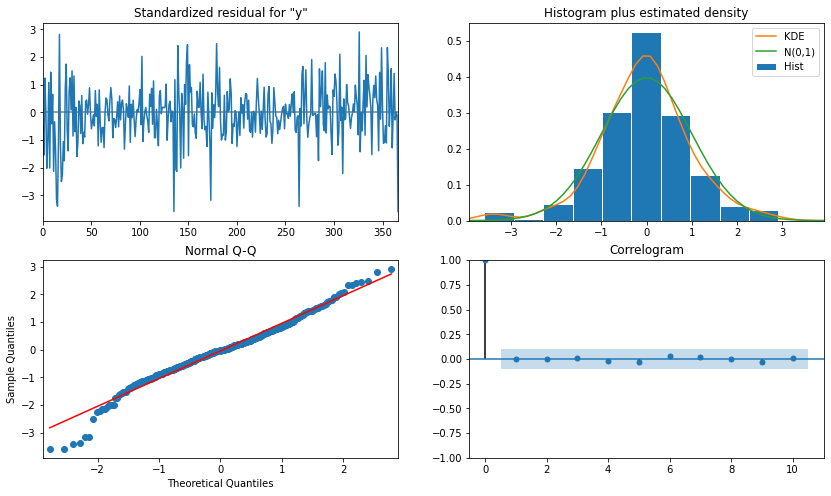

In [42]:
model_fit.plot_diagnostics(figsize=(14,8))
plt.show()


*   Tính accuracy metrics cho model (chọn độ đo RMSE)

In [43]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18.259


*   Visualize giá trị predict và real

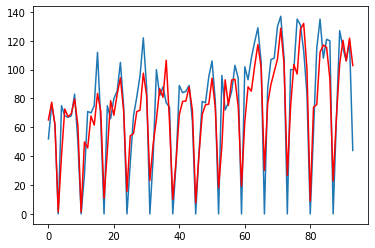

In [44]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
#Dự đoán cho 7 ngày tới
# y = model_fit.predict(1,7)
# print(y)